## Imports

In [1]:
# Common imports
import numpy as np
import os
import pandas as pd
import seaborn as sns
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    

## 3. Tackle the Titanic dataset

In [7]:
import urllib.request

TITANIC_PATH = os.path.join("datasets", "titanic")
DOWNLOAD_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/titanic/"

def fetch_titanic_data(url=DOWNLOAD_URL, path=TITANIC_PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    for filename in ("train.csv","test.csv"):
        filepath = os.path.join(path,filename)
        if not os.path.isfile(filepath):
            print("Downloading",filename)
            urllib.request.urlretrieve(url + filename, filepath)

fetch_titanic_data()    

In [8]:
def load_titanic_data(filename,titanicPath = TITANIC_PATH):
    csv_path = os.path.join(titanicPath,filename)
    return pd.read_csv(csv_path)

In [9]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [10]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **PassengerId**: a unique identifier for each passenger
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

Let's explicitly set the `PassengerId` column as the index column:

In [11]:
train_data = train_data.set_index("PassengerId")
test_data = test_data.set_index("PassengerId")

In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


Okay, the **Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null), especially the **Cabin** (77% are null). We will ignore the **Cabin** for now and focus on the rest. The **Age** attribute has about 19% null values, so we will need to decide what to do with them. Replacing null values with the median age seems reasonable. We could be a bit smarter by predicting the age based on the other columns (for example, the median age is 37 in 1st class, 29 in 2nd class and 24 in 3rd class), but we'll keep things simple and just use the overall median age.

The **Name** and **Ticket** attributes may have some value, but they will be a bit tricky to convert into useful numbers that a model can consume. So for now, we will ignore them.

In [25]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

(array([ 32.,  26., 103., 216.,  59.,  32.,  16.,   2.,   3.,   2.]),
 array([ 0.4167 ,  7.77503, 15.13336, 22.49169, 29.85002, 37.20835,
        44.56668, 51.92501, 59.28334, 66.64167, 74.     ]),
 <BarContainer object of 10 artists>)

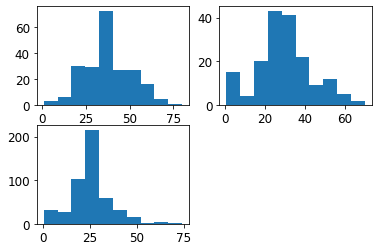

In [117]:
a1 = train_data[train_data['Pclass'] == 1]['Age']
a2 = train_data[train_data['Pclass'] == 2]['Age']
a3 = train_data[train_data['Pclass'] == 3]['Age']
plt.subplot(2,2,1)
plt.hist(a1)
plt.subplot(2,2,2)
plt.hist(a2)
plt.subplot(2,2,3)
plt.hist(a3)

In [118]:
a1 = a1.mean()
a2 = a2.median()
a3 = a3.median()

In [119]:
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,880.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.067235,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.327153,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.416700,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,26.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,37.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Let's check that the target is indeed 0 or 1:* Yikes, only 38% **Survived**! 😭 That's close enough to 40%, so accuracy will be a reasonable metric to evaluate our model.
* The mean **Fare** was £32.20, which does not seem so expensive (but it was probably a lot of money back then).
* The mean **Age** was less than 30 years old.

Let's check that the target is indeed 0 or 1:

In [120]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [121]:
tr = train_data
tr

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,24.0,1,2,W./C. 6607,23.4500,NaN,S


In [122]:
tr["Age"] = np.where((tr['Pclass'] == 1) & (tr['Age'].isnull()),a1,tr.Age)
tr["Age"] = np.where((tr['Pclass'] == 2) & (tr['Age'].isnull()),a2,tr.Age)
tr["Age"] = np.where((tr['Pclass'] == 3) & (tr['Age'].isnull()),a3,tr.Age)

In [193]:
tr

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen 'Carrie'",female,24.0,1,2,W./C. 6607,23.4500,NaN,S


In [194]:
train_data = tr

## Build Pipelines

In [209]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

In [210]:
from sklearn.preprocessing import OneHotEncoder

In [211]:
cat_pipeline = Pipeline([
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("cat_encoder",OneHotEncoder(sparse=False))
])

Finally, let's join the numerical and categorical pipelines:

In [212]:
from sklearn.compose import ColumnTransformer
num_attribs = ["Age","SibSp","Parch","Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

preprocess_pipeline = ColumnTransformer([
    ("num",num_pipeline,num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [213]:
X_train = preprocess_pipeline.fit_transform(
    train_data[num_attribs + cat_attribs])
X_train

array([[-0.53383309,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.67489039,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.23165222, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.38274265,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.23165222, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.22161908, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

In [214]:
X_train.shape

(891, 12)

In [215]:
len(train_data.columns)

11

In [216]:
y_train = train_data["Survived"]

#### Train

In [219]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### Test

In [220]:
X_test = preprocess_pipeline.transform(test_data[num_attribs + cat_attribs])
y_pred = forest_clf.predict(X_test)

#### Cross-Validation

In [221]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8148938826466916

In [222]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.8249313358302123

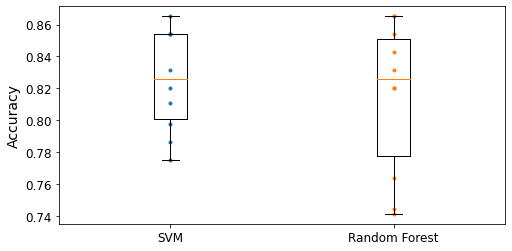

In [224]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, forest_scores, ".")
plt.boxplot([svm_scores, forest_scores], labels=("SVM","Random Forest"))
plt.ylabel("Accuracy", fontsize=14)
plt.show()